In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Patch


# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the throughput data using rolling mean
def smooth_throughput(df, window_size=5):
    df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Create directory if it doesn't exist
output_dir = 'work_dealing_stealing_fixed'
os.makedirs(output_dir, exist_ok=True)

custom_palette = ["#ba9344", "#7402d8"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='WORK_DEALING_NEW_QUEUE_AND_THREAD'),
    Patch(facecolor=custom_palette[1], label='WORK_STEALING')
]
hue_order = ['WORK_DEALING_NEW_QUEUE_AND_THREAD', 'WORK_STEALING']
labels = ['WORK DEALING', 'WORK_STEALING']

    
df = pd.read_csv("throughput_results_nebulastream_concat.csv")
df['normalized_timestamp'] = df['normalized_timestamp'] / 1000
df

,normalized_timestamp,query_id,throughput,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType
0,0.0,1,720.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE
1,0.5,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE
2,1.0,1,980.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE
3,1.5,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE
4,2.0,1,980.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
812891,791.5,156,1020.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE
812892,791.5,155,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE
812893,791.5,154,960.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE
812894,791.5,153,880.0,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE


/tmp/ipykernel_51476/1354580419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


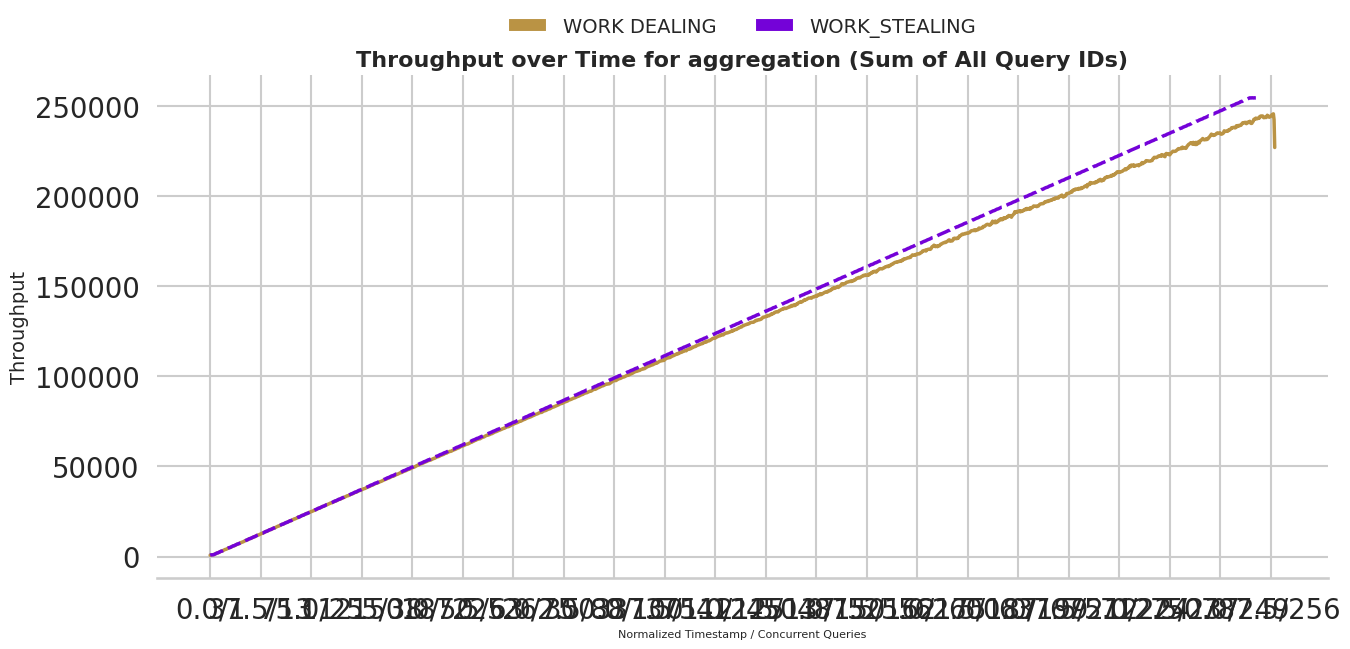

/tmp/ipykernel_51476/1354580419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


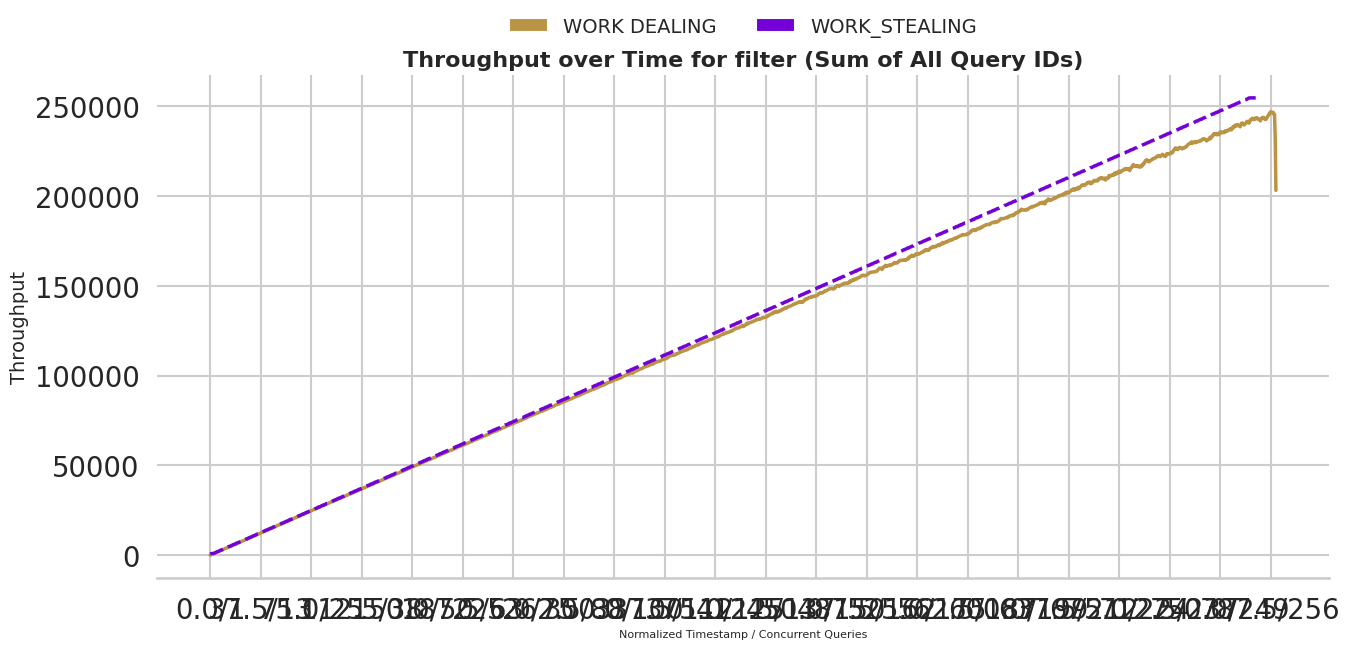

In [2]:
# Only keep timestamps smaller than n
#n = 100
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).sum(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', palette=custom_palette, hue_order=hue_order, hue='resourceAssignment', style='resourceAssignment', linewidth=2.5)

    ## Add vertical lines at the first occurrence of each query_id
    #for timestamp in first_timestamps:
    #    plt.axvline(x=timestamp, color='gray', linestyle='--', alpha=0.7)

    # Customize x-axis ticks to show every 5th timestamp and concurrent query count
    unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
    step = 75
    plt.xticks(ticks=unique_timestamps[::step],
               labels=[f"{ts}/{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
                       for ts in unique_timestamps[::step]],
               rotation=0, ha='center')

    plt.title(f'Throughput over Time for {query} (Sum of All Query IDs)', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    #plt.legend(title='Resource Assignment', title_fontsize=12, fontsize=12)
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False)        
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate.pdf'))
    plt.show()

/tmp/ipykernel_51476/1354580419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


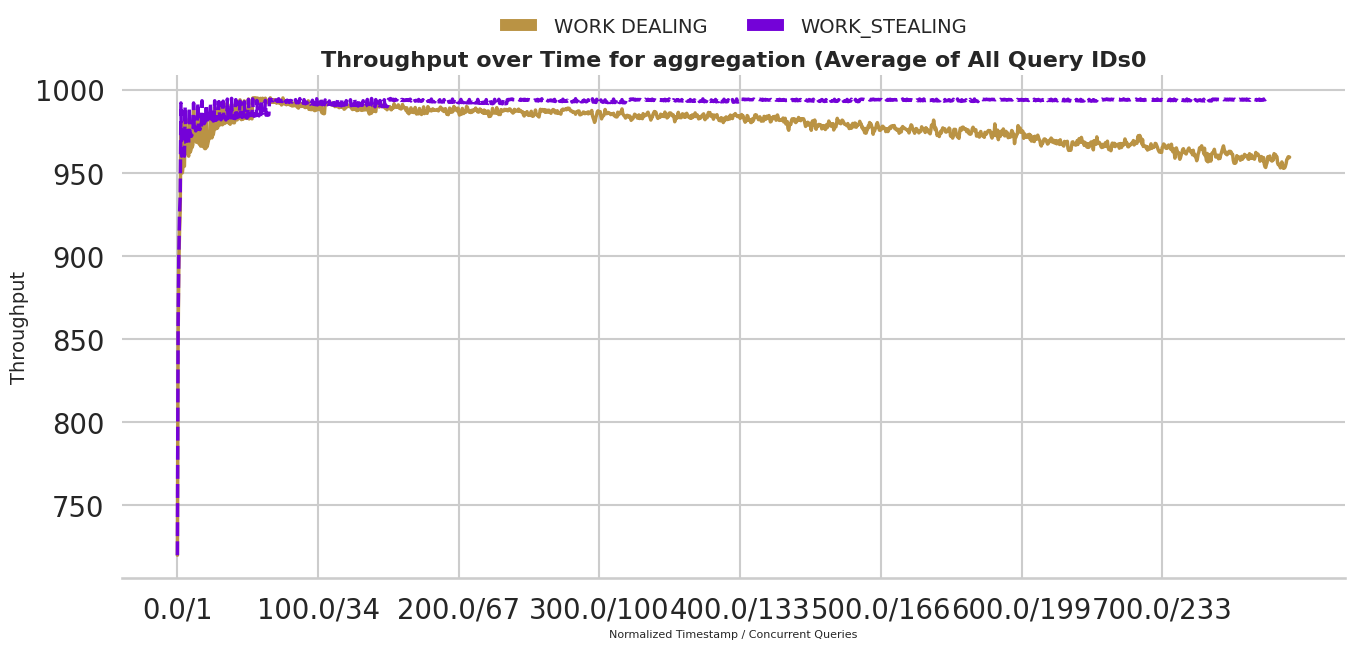

/tmp/ipykernel_51476/1354580419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


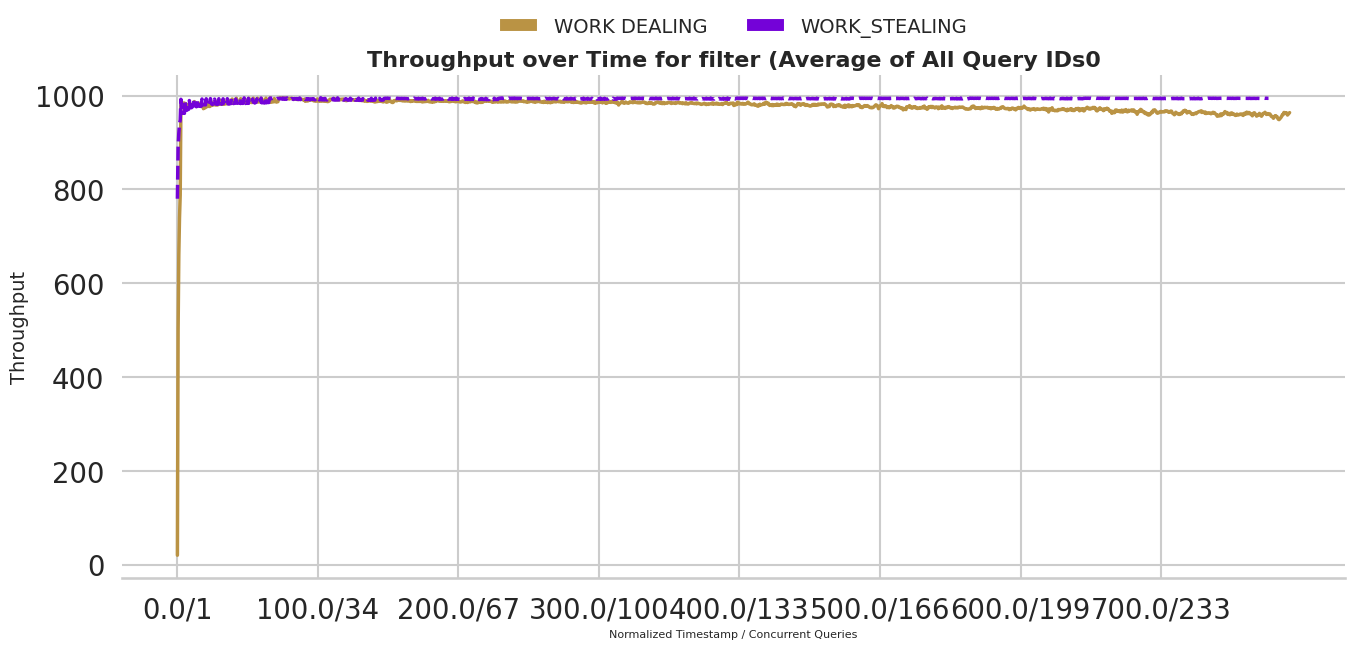

In [3]:
# Only keep timestamps smaller than n
#n = 600
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='resourceAssignment', style='resourceAssignment', palette=custom_palette, hue_order=hue_order, linewidth=2.5)

    ## Add vertical lines at the first occurrence of each query_id
    #for timestamp in first_timestamps:
    #    plt.axvline(x=timestamp, color='gray', linestyle='--', alpha=0.7)

    # Customize x-axis ticks to show every 5th timestamp and concurrent query count
    unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
    step = 200
    plt.xticks(ticks=unique_timestamps[::step],
               labels=[f"{ts}/{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
                       for ts in unique_timestamps[::step]],
               rotation=0, ha='center')

    plt.title(f'Throughput over Time for {query} (Average of All Query IDs0', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate_throughput.pdf'))
    plt.show()

In [4]:
%%script echo skipping
# Plot 2: Each query separately (hue: query_id) but separate plots per resource assignment and per query
resource_assignments = df['resourceAssignment'].unique()

for resource in resource_assignments:
    for query in queries:
        plt.figure(figsize=(14, 7))
        resource_query_df = df[(df['resourceAssignment'] == resource) & (df['query'] == query)]
        smoothed_df = smooth_throughput(resource_query_df)
        ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='query_id', style='query_id', palette='magma', linewidth=2.5)

        ## Customize x-axis ticks to show every 5th timestamp and concurrent query count
        #unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
        #step = 200
        #plt.xticks(ticks=unique_timestamps[::step],
        #           labels=[f"{ts}\n{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
        #                   for ts in unique_timestamps[::step]],
        #           rotation=45, ha='right')

        plt.title(f'Throughput over Time for {resource} - {query}', fontsize=16, fontweight='bold')
        plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=14)
        plt.ylabel('Throughput', fontsize=14)
        plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=2,
            frameon=False) 
        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

skipping


In [5]:
# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the latency data using rolling mean
def smooth_latency(df, window_size):
    df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Function to smooth only the latency data using Exponential Moving Average
def smooth_latency_ema(df, span):
    df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
    df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
    return df
    
df = pd.read_csv("latency_results_nebulastream_concat.csv")
df['normalized_start_timestamp'] = df['normalized_start_timestamp'] / 1000
df['normalized_end_timestamp'] = df['normalized_end_timestamp'] / 1000
df['latency_in_ms'] = df['latency'] * 1000
df['latency_in_us'] = df['latency'] * 1000 * 1000
df

,query_id,number_of_tasks,normalized_start_timestamp,normalized_end_timestamp,latency,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType,latency_in_ms,latency_in_us
0,1,1,0.000,0.000,1.620000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001620,1.620
1,1,1,0.010,0.010,1.690000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001690,1.690
2,1,1,0.020,0.020,1.082000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001082,1.082
3,1,1,0.030,0.030,8.410000e-07,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.000841,0.841
4,1,1,0.040,0.040,1.743000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001743,1.743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029718,253,1,792.031,792.031,2.839000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002839,2.839
40029719,252,1,792.031,792.031,2.295000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002295,2.295
40029720,254,1,792.033,792.033,2.398000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002398,2.398
40029721,255,1,792.034,792.034,5.992000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.005992,5.992


/tmp/ipykernel_51476/3787161799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_51476/3787161799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
/tmp/ipykernel_51476/1254042469.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

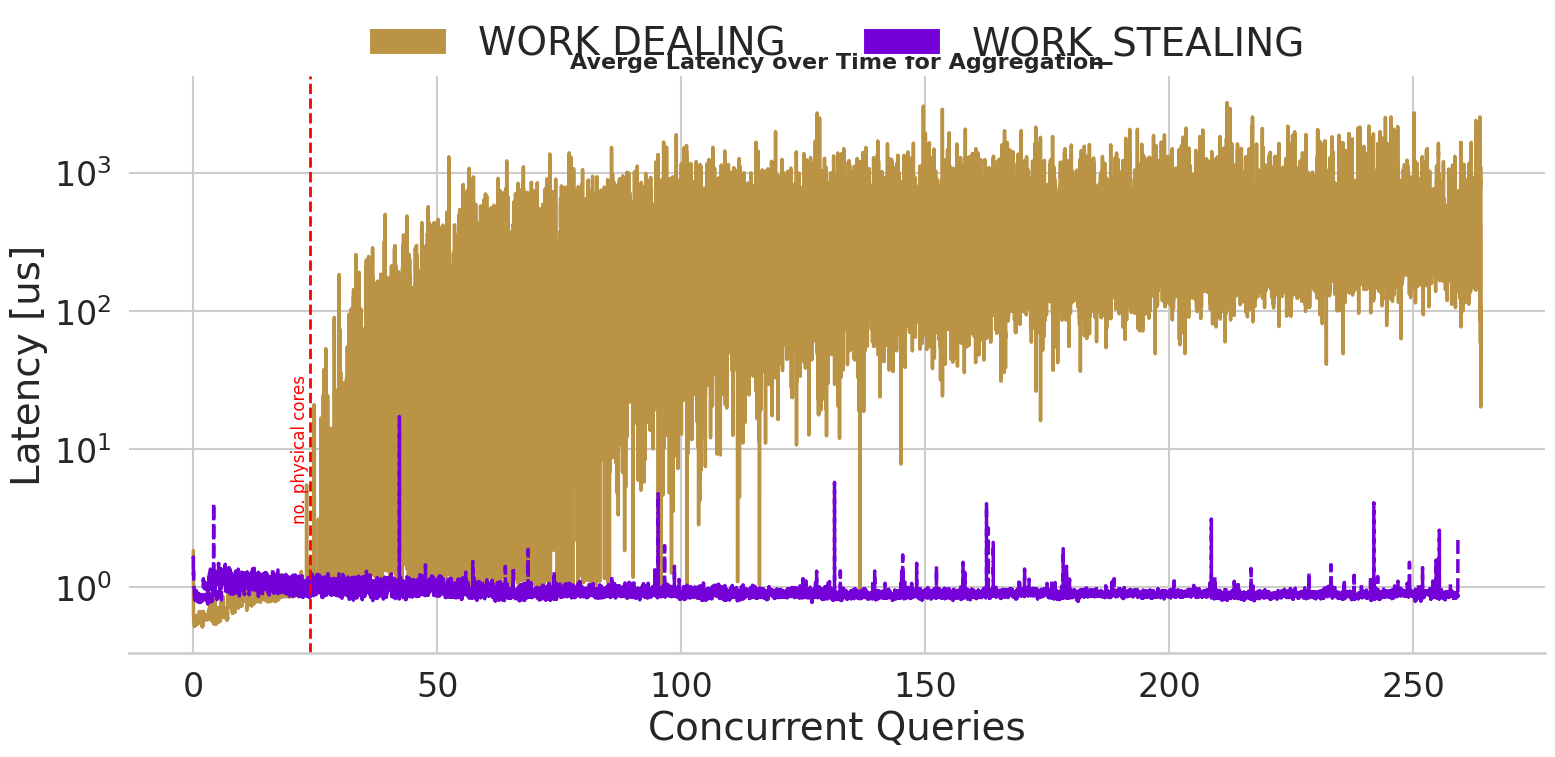

/tmp/ipykernel_51476/3787161799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_51476/3787161799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
/tmp/ipykernel_51476/1254042469.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

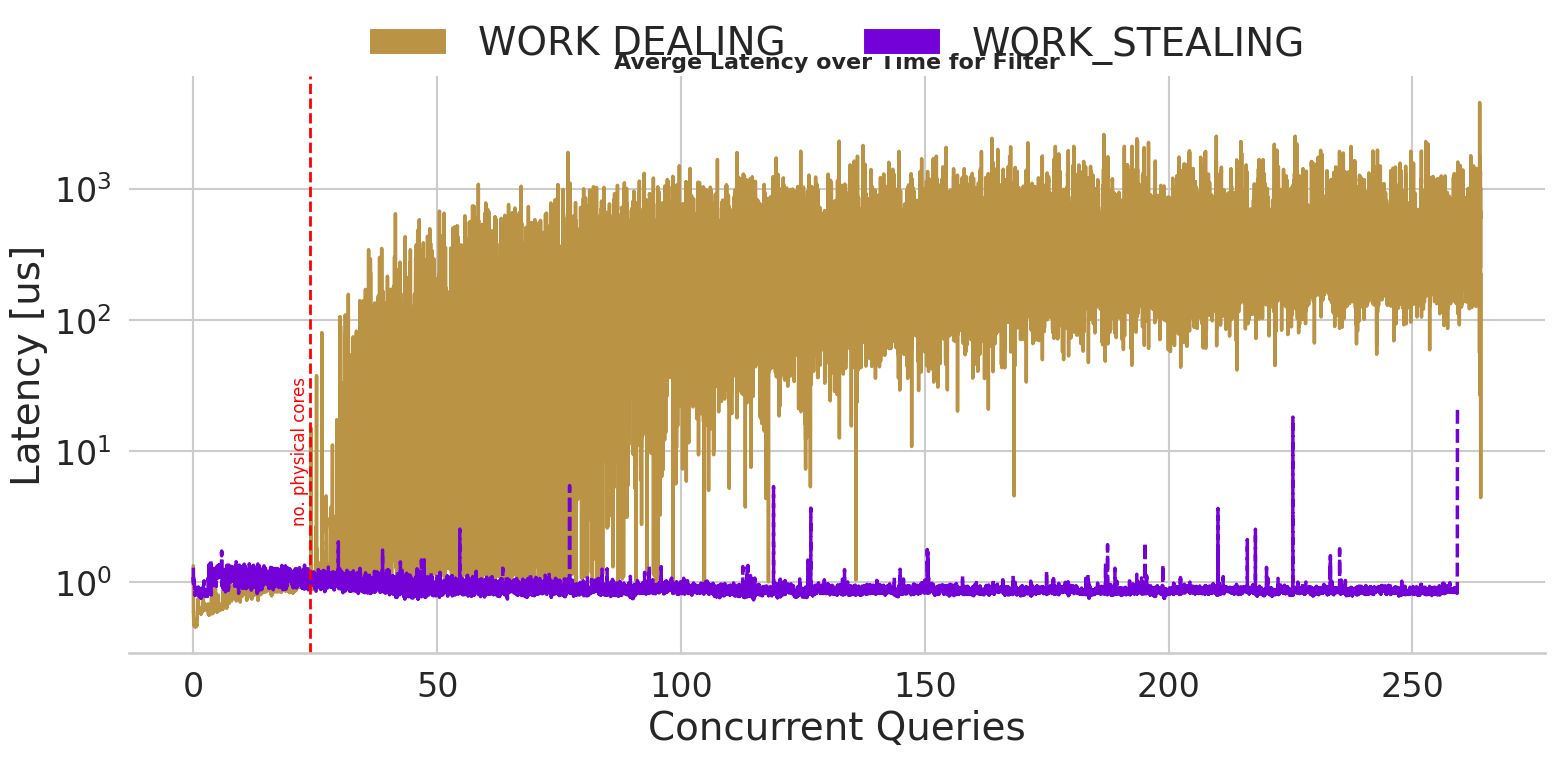

In [6]:
# Only keep timestamps smaller than n
#n = 100
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_start_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_start_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(top=0.85, bottom=0.15)  # Adjust top and bottom margins
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_start_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_latency(query_df, 50)

    # Divide the values by 3, as we start a new query every 3 seconds
    smoothed_df['concurrent_queries'] = smoothed_df['normalized_start_timestamp'] / 3

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='concurrent_queries', y='latency_in_us', hue='resourceAssignment', style='resourceAssignment', palette=custom_palette, hue_order=hue_order, linewidth=2.5)
    # Draw a vertical line at x = 24
    plt.axvline(x=24, color='red', linestyle='--', linewidth=2)
    
    # Add text to the vertical line
    plt.text(20.1, 10, 'no. physical cores', color='red', rotation=90, verticalalignment='center', fontsize=12)

    plt.title(f'Averge Latency over Time for {str(query).capitalize()}', fontsize=16, fontweight='bold')
    plt.xlabel('Concurrent Queries', fontsize=28)
    plt.xticks(rotation=0, fontsize=24)
    plt.yticks(rotation=0, fontsize=24)
    plt.ylabel('Latency [us]', fontsize=28)
    plt.legend(title='', handles=legend_handles, fontsize=28, title_fontsize=18, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    sns.despine(left=True)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate_latency.pdf'))
    plt.show()

In [7]:
df['normalized_start_timestamp'] = pd.to_datetime(df['normalized_start_timestamp'], unit='s')
df

,query_id,number_of_tasks,normalized_start_timestamp,normalized_end_timestamp,latency,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType,latency_in_ms,latency_in_us
0,1,1,1970-01-01 00:00:00.000,0.000,1.620000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001620,1.620
1,1,1,1970-01-01 00:00:00.010,0.010,1.690000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001690,1.690
2,1,1,1970-01-01 00:00:00.020,0.020,1.082000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001082,1.082
3,1,1,1970-01-01 00:00:00.030,0.030,8.410000e-07,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.000841,0.841
4,1,1,1970-01-01 00:00:00.040,0.040,1.743000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001743,1.743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029718,253,1,1970-01-01 00:13:12.031,792.031,2.839000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002839,2.839
40029719,252,1,1970-01-01 00:13:12.031,792.031,2.295000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002295,2.295
40029720,254,1,1970-01-01 00:13:12.033,792.033,2.398000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002398,2.398
40029721,255,1,1970-01-01 00:13:12.034,792.034,5.992000e-06,8192,4000000,COMPILER,HASH_JOIN,10,16,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.005992,5.992


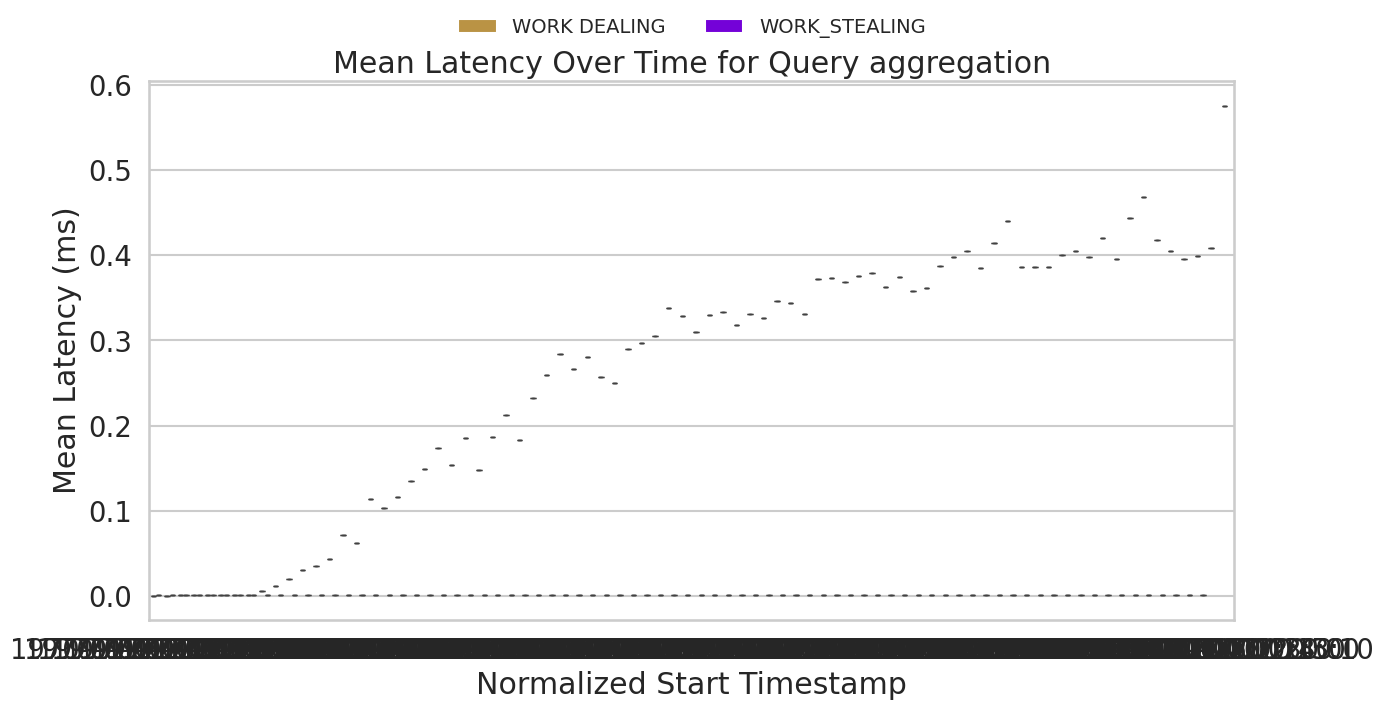

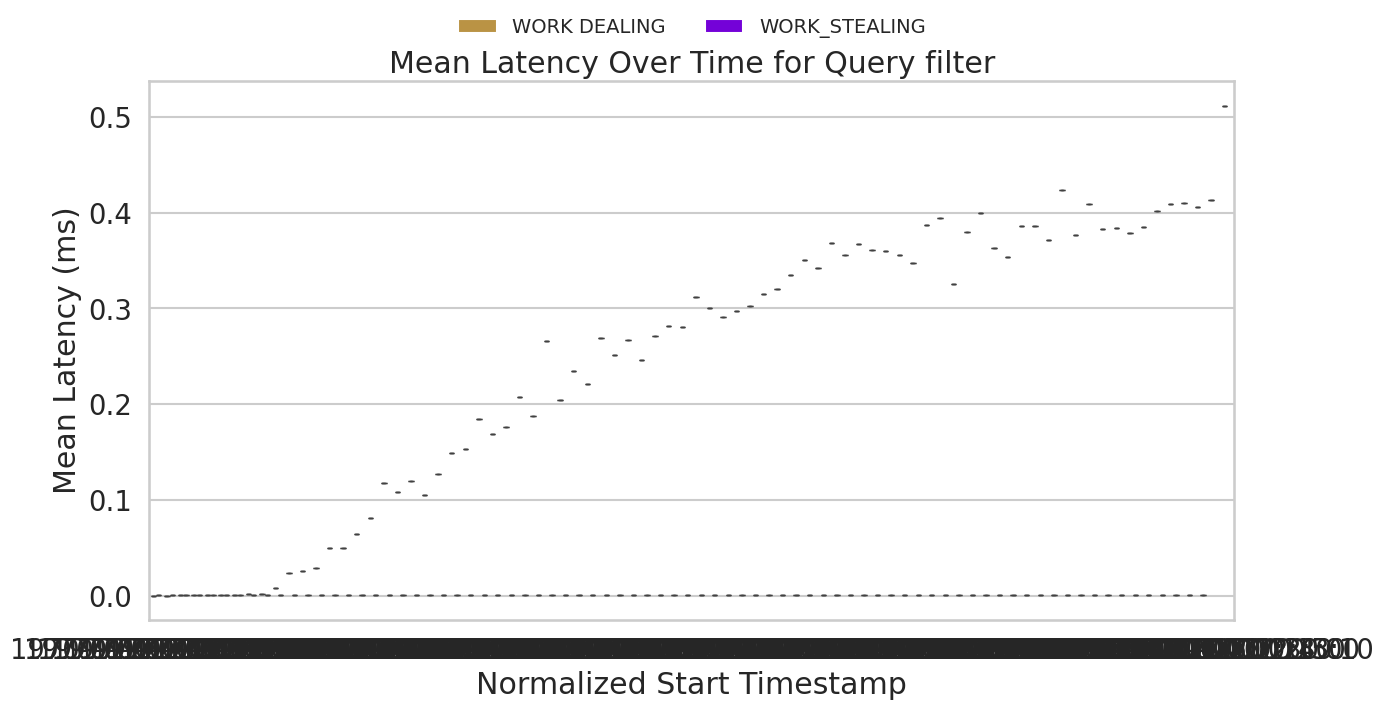

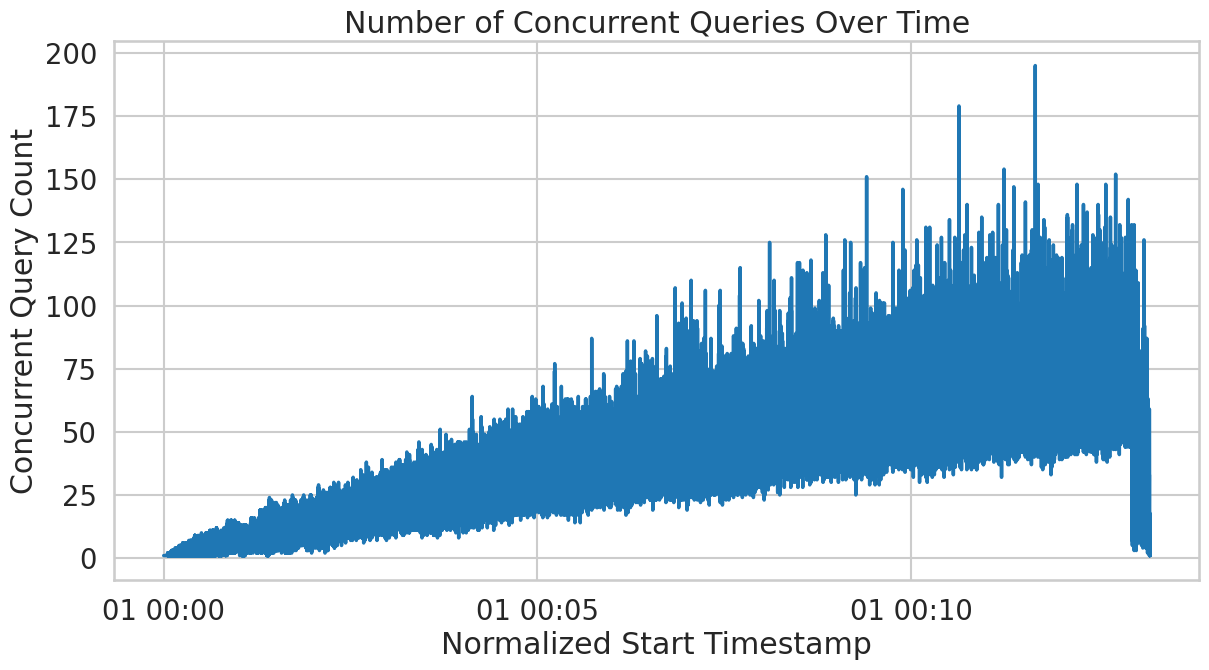

In [8]:
# Only keep timestamps smaller than n
#n = 100
#df = df[df['normalized_timestamp'] <= n]

# Define the bin size as 10 seconds
if df['normalized_start_timestamp'].dtype != 'datetime64[ns]':
    df['normalized_start_timestamp'] = pd.to_datetime(df['normalized_start_timestamp'], unit='s')
bin_size = '10s'

# Aggregate data for the first plot: Mean of throughput for each query and resource assignment
df_mean = df.groupby(['query', 'normalized_start_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the number of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_start_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Get unique queries
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))

    # Filter data for the current query
    query_df = df_mean[df_mean['query'] == query]

    # Calculate the mean of latency for each bin
    binned_data = query_df.groupby(['resourceAssignment', pd.Grouper(key='normalized_start_timestamp', freq=bin_size)])['latency_in_ms'].mean().reset_index()
    
    # Plot the binned data
    sns.boxplot(data=binned_data, x='normalized_start_timestamp', y='latency_in_ms', hue='resourceAssignment', palette=custom_palette, hue_order=hue_order)

    plt.title(f'Mean Latency Over Time for Query {query}')
    plt.xlabel('Normalized Start Timestamp')
    plt.ylabel('Mean Latency (ms)')
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    plt.show()

# Plot the number of concurrent queries over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=concurrent_queries, x='normalized_start_timestamp', y='concurrent_query_count', linewidth=2.5)
plt.title('Number of Concurrent Queries Over Time')
plt.xlabel('Normalized Start Timestamp')
plt.ylabel('Concurrent Query Count')
plt.show()